In [1]:
from bayes_tec.datapack import DataPack
import numpy as np
import pylab as plt

2018-07-21 20:25:02,186 Appending to /home/josh/git/bayes_tec/notebooks/devel/datapack_test_solver.hdf5.
2018-07-21 20:25:02,189 Closing table.
2018-07-21 20:25:02,190 Appending to /home/josh/git/bayes_tec/notebooks/devel/datapack_test_solver.hdf5.


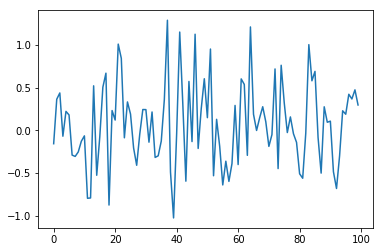

(62, 100)


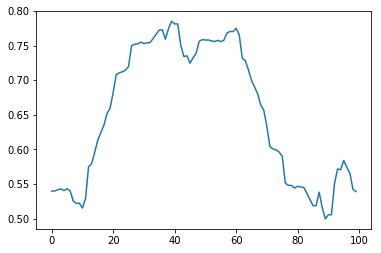

/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


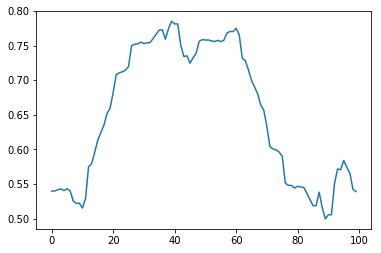

/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


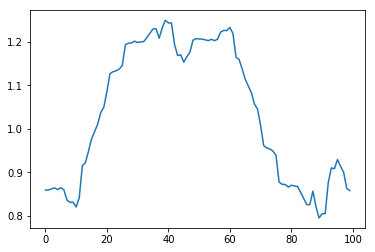

2018-07-21 20:25:02,742 Closing table.


In [66]:
from scipy.ndimage.filters import convolve
def w(x):
    return np.angle(np.exp(1j*x))

with DataPack('/net/rijn/data2/rvweeren/LOFARHBA_A665/DR2Josh/SOLSDIRjos/P126+65_all_chan.hdf5') as d:
    Y,_ = d.phase
    N = 50
    Y = Y[0,0,:,0,:]

    plt.plot(Y[51,:])
    plt.show()
    dY = w(w(Y[:,1:]) - w(Y[:,:-1]))
    dY = np.pad(dY,((0,0),(0,1)),mode='symmetric')
    dY *= dY
    uncert = np.zeros_like(Y)
    for i in range(-(N>>1),N>>1):
        uncert += np.roll(dY,i,axis=1)
    uncert /= N
    uncert = np.sqrt(uncert)
    
#     k = np.ones((1,N))/N
#     uncert = np.sqrt(convolve(dY**2,k,mode='reflect'))
# #     uncert = np.sqrt(np.convolve(dY**2, np.ones((N,))/N, mode='valid',))
    print(uncert.shape)
    plt.plot(uncert[51,:])
    plt.show()
    weights = 1./uncert**2
    plt.plot(1./np.sqrt(weights[51,:]))
    plt.show()
    weights /= np.mean(weights,axis=1,keepdims=True)
    plt.plot(1./np.sqrt(weights[51,:]))
    plt.show()

In [85]:
from concurrent import futures

def _parallel_shift(arg):
    position, dY2 = arg
    return np.roll(dY2, position, axis=1)

def calulate_weights(Y,N=200, min_uncert=1e-3, phase_wrap = True, num_threads=None):
    """
    Get a weight matrix for each datapoint in Y using moving average of TD.
    The values must [N, Nt], Nt is uncorrelated axis
    Y: array shape [N, Nt], independent axis
    N : int the window
    Returns:
    weights [N, Nt] and mean_uncert float
    """
    
    if phase_wrap:
        z = np.exp(1j*Y)
        args = []
        for i in range(-(N>>1),N-(N>>1)):
            args.append((i, z))

        with futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            jobs = executor.map(_parallel_shift,args)
            results = list(jobs)# each is N, Nt but rolled
        for r in results[1:]:
            results[0] += r
        results[0] /= N
        z_mean = results[0]
        R2 = z_mean * z_mean.conj()
        Re2 = N/(N-1)*(R2 - 1./N)
        var = -np.log(Re2)
    else:
        args = []
        for i in range(-(N>>1),N-(N>>1)):
            args.append((i, Y))
        with futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
            jobs = executor.map(_parallel_shift,args)
            results = list(jobs)# each is N, Nt but rolled
        mean = results[0].copy()
        for r in results[1:]:
            mean += r
        mean /= N
        var = (results[0] - mean)**2
        for r in results[1:]:
            var += (r - mean)**2
        var /= N
    var = np.maximum(min_uncert**2, var)
    return 1./var

In [88]:
Y = 5*np.random.normal(size=[1000,1000])

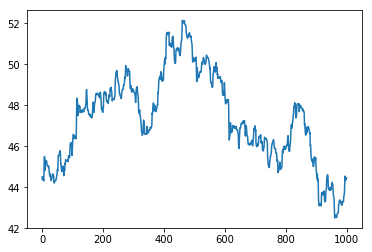

In [97]:
w = weights_and_mean_uncert(Y,N=500, num_threads=None)
plt.plot(1/w[51,:])
plt.show()

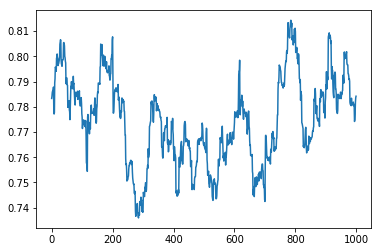

In [105]:
w = calulate_weights(Y,N=500, phase_wrap=False,num_threads=None)
w = w/np.max(w)
plt.plot(w[51,:])
plt.show()

In [ ]:
plt.plot(w[51,:]/np.mean(w,axis=1))
plt.show()

In [13]:
from bayes_tec.datapack import DataPack
from bayes_tec.utils.data_utils import calculate_weights
import numpy as np
import pylab as plt
plt.style.use('ggplot')

In [35]:
with DataPack('/net/rijn/data2/rvweeren/LOFARHBA_A665/DR2Josh/SOLSDIRjosh/P126+65_all_chan.hdf5',readonly=True) as d:
    d.select(ant='RS210HBA')
    Y,axes = d.phase
    time = d.get_times(axes['time'])
    N = 50

2018-08-16 14:21:46,650 Appending to /net/rijn/data2/rvweeren/LOFARHBA_A665/DR2Josh/SOLSDIRjosh/P126+65_all_chan.hdf5.
2018-08-16 14:21:46,653 Closing table.
2018-08-16 14:21:46,656 Reading from /net/rijn/data2/rvweeren/LOFARHBA_A665/DR2Josh/SOLSDIRjosh/P126+65_all_chan.hdf5.
2018-08-16 14:21:47,321 Closing table.


In [36]:
Y.shape
time

(array(['2016-12-08T23:12:13.006', '2016-12-08T23:20:41.006',
        '2016-12-08T23:20:49.006', ..., '2016-12-09T07:20:08.934',
        '2016-12-09T07:20:16.934', '2016-12-09T07:28:44.934'], dtype='<U23'),
 <Time object: scale='utc' format='mjd' value=[57730.96681719 57730.97269682 57730.97278942 ... 57731.30565895
  57731.30575155 57731.31163118]>)

In [25]:
weights = calculate_weights(Y,indep_axis=-1,N=200,min_uncert=10*np.pi/180.)

/net/lofar1/data1/albert/git/bayes_tec/src/bayes_tec/utils/data_utils.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
  var = -np.log(Re2).astype(Y.dtype)


In [26]:
var = 1./weights

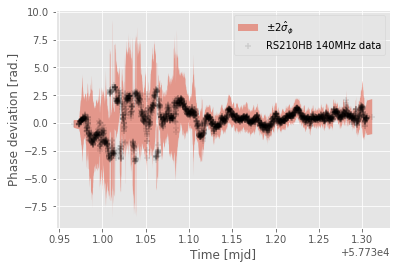

In [45]:
std = np.sqrt(var)
t = np.linspace(0,1,3600)
# plt.fill_between(t,Y[0,0,0,0,:]-std[0,0,0,0,:],Y[0,0,0,0,:]+std[0,0,0,0,:],alpha=0.1,color='blue')
plt.fill_between(time[1].mjd,Y[0,0,0,0,:]-2*std[0,0,0,0,:],Y[0,0,0,0,:]+2*std[0,0,0,0,:],alpha=0.5,label=r'$\pm2\hat{\sigma}_\phi$')#,color='blue')
plt.scatter(time[1].mjd,Y[0,0,0,0,:],marker='+',alpha=0.1,color='black',label='RS210HB 140MHz data')
plt.legend()
plt.xlabel('Time [mjd]')
plt.ylabel('Phase deviation [rad.]')
plt.savefig('/home/albert/ftp/moving_variance.png')
plt.show()